# Segmenting and Clustering Neighborhoods in Toronto

## 1. WebScraping Torontos Neighbourhoods and Boroughs

First import necessary packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

import urllib.request
from urllib.request import urlopen

Get neighbourshoods from Wikipedia

In [2]:
# read in url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 

#convert
soup = BeautifulSoup(html, 'html.parser')

#find the table
soup = soup.find('table',attrs={'class': 'wikitable'})
print(soup)

<table class="wikitable sortable">
<tbody><tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A
</td>
<td>North York
</td>
<td>Parkwoods
</td></tr>
<tr>
<td>M4A
</td>
<td>North York
</td>
<td>Victoria Village
</td></tr>
<tr>
<td>M5A
</td>
<td>Downtown Toronto
</td>
<td>Regent Park, Harbourfront
</td></tr>
<tr>
<td>M6A
</td>
<td>North York
</td>
<td>Lawrence Manor, Lawrence Heights
</td></tr>
<tr>
<td>M7A
</td>
<td>Downtown Toronto
</td>
<td>Queen's Park, Ontario Provincial Government
</td></tr>
<tr>
<td>M8A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M9A
</td>
<td>Etobicoke
</td>
<td>Islington Avenue, Humber Valley Village
</td></tr>
<tr>
<td>M1B
</td>
<td>Scarborough
</td>
<td>Malvern, Rouge
</td></tr>
<tr>
<td>M2B
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3B
</td>
<td

In [3]:
#Create array to hold the data we extract
postal = []
borough = []
neighbourhood = []

rows = soup.find_all('tr')

#skip the title
rows = rows[1:]

for row in rows:
    cells = row.find_all('td')
        
    code = cells[0]
    postal.append(code.text.strip())
            
    boroughs = cells[1]
    borough.append(boroughs.text.strip())
            
    neigh = cells[2]
    neighbourhood.append(neigh.text.strip())

In [4]:
#Create dataframe to hold the data we extract
df = pd.DataFrame()

df['Postal Code'] = postal
df['Borough'] = borough
df['Neighbourhood'] = neighbourhood

df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
#get rid of "Not assigned" boroughs
df = df[df.Borough != 'Not assigned']

#assign same neighbourhood as borough if neighborhood is "Not assigned"
df['Neighbourhood'] = df.apply(lambda x: x.Borough if x.Neighbourhood=="Not assigned" else x.Neighbourhood, axis = 1)

df.shape

(103, 3)

## 2. Get Geodata for Toronto

Try Geocoder first:

In [6]:
#testing if geocoder works:
#!pip install geocoder
#import geocoder # import geocoder

# initialize your variable to None
#lat_lng_coords = None

# loop until you get the coordinates
#while(lat_lng_coords is None):
 # g = geocoder.google('{}, Toronto, Ontario'.format('MG5'))
 # lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

Geocoder doesn't seem to work, so I'll import the Geodata using the provided __dataset__:

In [7]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d8f0c100ea2a47078f882836baf8aa05 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Z4wvsi6lSQjcvH_oE2XqV_2wJ9Db_xp87wXkna4IHlet',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_d8f0c100ea2a47078f882836baf8aa05.get_object(Bucket='courseracapstone-donotdelete-pr-ln3lnkesy1oaof',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Geocodes= pd.read_csv(body)
Geocodes.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


__Merge__ the scraped data with the geodata:

In [8]:
df_merge = pd.merge(df, Geocodes, on='Postal Code')

df_merge.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## 3. Cluster Analysis of Toronto

Read in necessary packages:

In [10]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

__Map of Toronto and its neighbourhoods:__

In [11]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

__Define Foursquare Credentials and Version__

In [12]:
CLIENT_ID = 'WGOYBSKFD53VPMIRFJH1ZJXSEEQ3SARJ2SHCCMBQDOISAKKA' # your Foursquare ID
CLIENT_SECRET = 'DFF3Q5ZWIRV0H5CCGWATHVTVVNMTYPFIYBMCVRJ3ACTFANDW' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WGOYBSKFD53VPMIRFJH1ZJXSEEQ3SARJ2SHCCMBQDOISAKKA
CLIENT_SECRET:DFF3Q5ZWIRV0H5CCGWATHVTVVNMTYPFIYBMCVRJ3ACTFANDW


__Define function that obtains the top venues for each neighbourhood__

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the venues for Toronto:

In [14]:
toronto_venues = getNearbyVenues(names=df_merge['Neighbourhood'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

__Let's check the size of the resulting dataframe__

In [15]:
print(toronto_venues.shape)
toronto_venues.head()

(2136, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


__Venues by neighbourhood__

In [16]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18


__Number of categories:__

In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 268 uniques categories.


#### Analyse neighbourhoods:

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Mean frequency for each neighbourhood:__

In [19]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8,"Business reply mail Processing Centre, South C...",0.055556,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.0000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.062500,0.0625,0.0625,0.125,0.1875,0.0625,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [20]:
toronto_grouped.shape

(95, 268)

__Let's write a function to sort the venues in descending order.__

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

__Top 10 most common venues for each neighbourhood__

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Gym,Airport Food Court,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Fried Chicken Joint,Shopping Mall,Bridal Shop,Sandwich Place,Diner,Deli / Bodega,Supermarket,Sushi Restaurant
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Comfort Food Restaurant,Thai Restaurant,Juice Bar,Fast Food Restaurant,Butcher,Café


### Cluster Neighbourhoods

Applying the __Elbow-Method__ to determine the number of clusters:

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


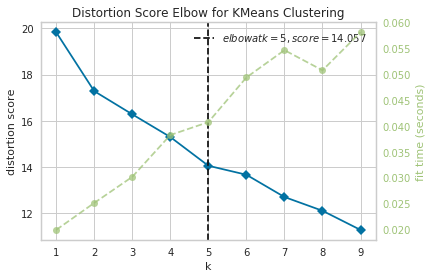

In [23]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The Elbow-Method suggests __5 clusters__:

In [29]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

toronto_merged = df_merge

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged = toronto_merged.dropna()
toronto_merged# check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,3.0,Food & Drink Shop,Park,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,1.0,Pizza Place,Coffee Shop,French Restaurant,Portuguese Restaurant,Hockey Arena,Eastern European Restaurant,Dumpling Restaurant,Electronics Store,Drugstore,Department Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,1.0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Bank,Spa,Beer Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,1.0,Clothing Store,Women's Store,Coffee Shop,Boutique,Miscellaneous Shop,Furniture / Home Store,Arts & Crafts Store,Event Space,Accessories Store,Vietnamese Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,0.0,Coffee Shop,Diner,Café,Bar,Bank,Mexican Restaurant,Sushi Restaurant,Distribution Center,Japanese Restaurant,Fried Chicken Joint
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4.0,1.0,Fast Food Restaurant,Dessert Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
7,M3B,North York,Don Mills,43.745906,-79.352188,1.0,1.0,Gym,Beer Store,Japanese Restaurant,Coffee Shop,Restaurant,Athletics & Sports,Sandwich Place,Bike Shop,Bus Line,Sporting Goods Shop
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1.0,1.0,Pizza Place,Gastropub,Café,Athletics & Sports,Bank,Intersection,Breakfast Spot,Gym / Fitness Center,Pharmacy,Electronics Store
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1.0,1.0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Electronics Store,Ramen Restaurant,Middle Eastern Restaurant
10,M6B,North York,Glencairn,43.709577,-79.445073,1.0,1.0,Pub,Park,Japanese Restaurant,Metro Station,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


__Visualize__ the clusters:

In [32]:
# create map
map_clusters = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters